## 数据挖掘实践任务
任务描述

- 用逻辑回归、svm和决策树、随机森林和XGBoost进行模型构建（不需考虑调参）

ref:https://github.com/lizoo6zhi/Datawhale/blob/master/DataMining/Task3.ipynb

In [110]:
# 获取经过task02中特征选择处理过的数据集
import pandas as pd
dataset = pd.read_csv('./dataset/task2_proc.csv')
features = dataset.iloc[:, :-1]
labels = dataset.iloc[:, -1]
print('features shape:{}, labels shape:{}'.format(features.shape, labels.shape))

features shape:(4455, 50), labels shape:(4455,)


In [111]:
# 数据拆分
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


random_state=2018    # 后面会多次用到，故设置一个变量

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3,
                                                    random_state=2018)

# 对训练集进行标准话处理
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

In [112]:
model_score_train = []
decision_score_train = []
model_score_test = []
decision_score_test = []

def proc_score(y_pred, y_pred_scores, y_test, train=True):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    if train:
        decision_score_train.append(y_pred_scores)
        model_score_train.append([accuracy, precision, recall, f1, roc_auc])
        text = 'Train'
    else:
        decision_score_test.append(y_pred_scores)
        model_score_test.append([accuracy, precision, recall, f1, roc_auc])
        text = 'Test'
    
    print('{}: accuracy_score:{:.3f}, precision_score:{:.3f}, recall_score:{:.3f}, f1_score:{:.3f}, roc_auc_score:{:.3f}'.format(
    text, accuracy, precision, recall, f1, roc_auc))

In [113]:
from sklearn.linear_model import LogisticRegression    # 逻辑回归 
from sklearn.svm import SVC    # SVM 支持向量机
from sklearn.tree import DecisionTreeClassifier   # 决策树
from sklearn.ensemble import RandomForestClassifier   # 随机森林分类器
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict  #  随机搜索，交叉验证
#　https://www.cnblogs.com/jiaxin359/p/8552800.html
from scipy.stats import uniform    # 标准均匀分布
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## 逻辑回归

In [114]:
param_distributions = {'C':uniform(0,10)}
rs_clf  = RandomizedSearchCV(LogisticRegression(solver='liblinear'), 
                             param_distributions=param_distributions, 
                             cv=3,    # 
                             n_iter=100,
                             random_state=random_state,
                             verbose=2, # verbose是控制日志输出，0无输出，1简化输出，2详细输出
                             n_jobs=-1
                            )
rs_clf.fit(x_train_scale, y_train)
logistic = rs_clf.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.5s finished


In [115]:
y_pred = logistic.predict(x_train_scale)
y_pred_scores = cross_val_predict(logistic, 
                                  x_train_scale, 
                                  y_train, 
                                  cv=5,    # integer, to specify the number of folds in a (Stratified)KFold,
                                  method='decision_function'
                                  # method : string, optional, default: ‘predict’
                                 )
# 使用sklearn进行模型交叉验证：  https://www.cnblogs.com/jiaxin359/p/8552800.html
proc_score(y_pred, y_pred_scores, y_train, train=True)

y_pred = logistic.predict(x_test_scale)
y_pred_scores = cross_val_predict(logistic, x_test_scale, y_test, cv=5,
                                  method='decision_function')
proc_score(y_pred, y_pred_scores, y_test, train=False)

Train: accuracy_score:0.799, precision_score:0.713, recall_score:0.355, f1_score:0.474, roc_auc_score:0.653
Test: accuracy_score:0.791, precision_score:0.624, recall_score:0.349, f1_score:0.448, roc_auc_score:0.641


## SVM

In [116]:
param_distributions = {'C':uniform(0,10)}
rs_clf = RandomizedSearchCV(SVC(kernel='linear'),
                            param_distributions=param_distributions,
                            cv=3,
                            n_iter=100,
                            random_state=random_state,
                            verbose=2,
                            n_jobs=-1
                           )
rs_clf.fit(x_train_scale, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   42.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='linear', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fee9bad8a20>},
                   pre_dispatch='2*n_jobs', random_state=2018, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [117]:
svc = rs_clf.best_estimator_

y_pred = svc.predict(x_train_scale)
y_pred_scores = cross_val_predict(svc, x_train_scale, y_train,cv=3,
                                 method='decision_function')
proc_score(y_pred, y_pred_scores, y_train, train=True)

y_pred = svc.predict(x_test_scale)
y_pred_scores = cross_val_predict(svc, x_test_scale, y_test, cv=3,
                                 method='decision_function')
proc_score(y_pred, y_pred_scores, y_test, train=False)

Train: accuracy_score:0.789, precision_score:0.779, recall_score:0.243, f1_score:0.371, roc_auc_score:0.610
Test: accuracy_score:0.791, precision_score:0.696, recall_score:0.241, f1_score:0.358, roc_auc_score:0.604


## 决策树

In [118]:
dt_clf = DecisionTreeClassifier(max_depth=8)
dt_clf.fit(x_train_scale, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [119]:

y_pred = dt_clf.predict(x_train_scale)
y_pred_scores = cross_val_predict(dt_clf,x_train_scale,y_train,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

y_pred = dt_clf.predict(x_test_scale)
y_pred_scores = cross_val_predict(dt_clf,x_test_scale,y_test,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train: accuracy_score:0.893, precision_score:0.883, recall_score:0.671, f1_score:0.763, roc_auc_score:0.820
Test: accuracy_score:0.755, precision_score:0.492, recall_score:0.404, f1_score:0.444, roc_auc_score:0.636


## 随机森林

In [120]:
rf_clf = RandomForestClassifier(n_estimators=1000,  # 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数
                                criterion='gini',  # criterion: 即CART树做划分时对特征的评价标准
                                oob_score=True,  # oob_score :即是否采用袋外样本来评估模型的好坏
                                random_state=random_state,
                                verbose=0, 
                                n_jobs=-1
                               )
rf_clf.fit(x_train_scale, y_train)
rf_clf.oob_score_

0.7957023733162284

In [121]:
y_pred = rf_clf.predict(x_train_scale)
y_pred_scores = cross_val_predict(rf_clf,x_train_scale,y_train,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

y_pred = rf_clf.predict(x_test_scale)
y_pred_scores = cross_val_predict(rf_clf,x_test_scale,y_test,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train: accuracy_score:1.000, precision_score:1.000, recall_score:1.000, f1_score:1.000, roc_auc_score:1.000
Test: accuracy_score:0.802, precision_score:0.712, recall_score:0.306, f1_score:0.428, roc_auc_score:0.633


## XGBoost

In [122]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train_scale, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [123]:
y_pred = xgb.predict(x_train_scale)
y_pred_scores = cross_val_predict(xgb,x_train_scale,y_train,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

y_pred = xgb.predict(x_test_scale)
y_pred_scores = cross_val_predict(xgb,x_test_scale,y_test,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train: accuracy_score:0.846, precision_score:0.843, recall_score:0.491, f1_score:0.620, roc_auc_score:0.730
Test: accuracy_score:0.806, precision_score:0.707, recall_score:0.343, f1_score:0.462, roc_auc_score:0.649


## 对个模型进行比较

In [126]:
model_name = ['Logistic', 'SVM', 'DecisionTree', 'RandomForest', 'XGBoost']
columns = ['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score']
types = ['train', 'test']
pd_list = []

for train,test in zip(model_score_train,model_score_test):
    pd_list.append(pd.DataFrame([train,test],index=types,columns=columns))
    
pd.concat(pd_list, axis=0, keys=model_name) 

accuracy_score  precision_score  ...  f1_score  roc_auc_score
Logistic     train        0.798589         0.712846  ...  0.474037       0.652982
             test         0.791324         0.624309  ...  0.447525       0.640819
SVM          train        0.788967         0.779116  ...  0.370937       0.609858
             test         0.790576         0.696429  ...  0.357798       0.603589
DecisionTree train        0.893201         0.882838  ...  0.762651       0.820338
             test         0.754675         0.492481  ...  0.444068       0.635527
RandomForest train        1.000000         1.000000  ...  1.000000       1.000000
             test         0.801795         0.712230  ...  0.427646       0.633034
XGBoost      train        0.846376         0.842672  ...  0.620143       0.729569
             test         0.806283         0.707006  ...  0.461538       0.648591

[10 rows x 5 columns]

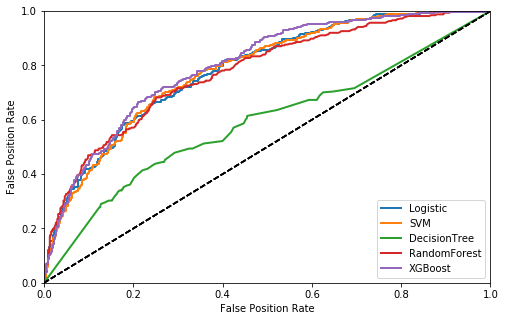

In [125]:

# 绘制ROC取下对比图
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')

for score,label in zip(decision_score_test,model_name):
    fpr,tpr,threshold = roc_curve(y_test,score)
    plot_roc_curve(fpr,tpr,label)
plt.rcParams['figure.figsize'] = (8,5)    
plt.axis([0,1,0,1])
plt.xlabel('False Position Rate')
plt.ylabel('False Position Rate')
plt.legend()
plt.show()